 
<h2>
    <center>
              Técnincas de Machine Learning </br>
    </center>
<h2>

 
<h3>
    <center>
            Atividade Somativa 2:
             Criando Sua Própria IA - Parte II
    </center>
<h3>

<h4>Dataset: CSGO Round Snapshots</h4>

##### Aluno: [Igor Michetti](https://github.com/igormichetti) </br>RA: 1112020102213


### 1. Carregar o Dataset

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [3]:
df = pd.read_excel('./datasets/Semana4/csgo_round_snapshots.xlsx')
df.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_money,t_money,ct_helmets,t_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0,0,de_dust2,500,500,4000,4000,0,0,...,0,0,0,0,0,0,0,0,0,CT
1,156.03,0,0,de_dust2,500,500,600,650,0,0,...,0,0,2,0,0,0,0,0,0,CT
2,96.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,2,0,0,0,0,0,0,CT
3,76.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,0,0,0,0,0,0,0,CT
4,174.97,1,0,de_dust2,500,500,18350,10750,0,0,...,0,0,0,0,0,0,0,0,0,CT


### 2. Divisão do Dataset

In [62]:
X = df.drop('round_winner', axis=1)
y = (df['round_winner'] == 'CT').astype(int).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Preparação dos Dados

In [63]:
# Define transformation functions
def time_left_transform(df):
    df['time_left'] = df['time_left'].astype(int)
    return df

def ct_ar_transform(df):
    ct_other_ar = ['ct_weapon_aug', 'ct_weapon_famas', 'ct_weapon_scar20', 'ct_weapon_sg553']
    df['ct_weapon_ar'] = df[ct_other_ar].sum(axis=1).astype(int)
    df = df.drop(ct_other_ar, axis=1)
    return df

def t_ar_transform(df):
    t_other_ar = ['t_weapon_aug', 't_weapon_famas', 't_weapon_g3sg1', 't_weapon_galilar', 't_weapon_m4a1s', 't_weapon_m4a4', 't_weapon_scar20', 't_weapon_sg553']
    df['t_weapon_ar'] = df[t_other_ar].sum(axis=1).astype(int)
    df = df.drop(t_other_ar, axis=1)
    return df

def pistols_transform(df):
    pistols_columns = {'t_weapon_glock', 'ct_weapon_usps', 'ct_weapon_deagle', 't_weapon_deagle', 't_weapon_p250', 'ct_weapon_p250', 'ct_weapon_p2000', 'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_fiveseven', 't_weapon_fiveseven', 't_weapon_tec9'}
    ct_pistol_columns = {col for col in pistols_columns if 'ct' in col}
    df['ct_pistols'] = df[list(ct_pistol_columns)].sum(axis=1).astype(int)
    df = df.drop(list(ct_pistol_columns), axis=1)

    t_pistol_columns = pistols_columns - ct_pistol_columns
    df['t_pistols'] = df[list(t_pistol_columns)].sum(axis=1).astype(int)
    df = df.drop(list(t_pistol_columns), axis=1)
    return df

def other_weapons_transform(df):
    weapon_columns = {col for col in df.columns if 'weapon' in col}
    meta_weapon_columns = {'ct_weapon_m4a4', 'ct_weapon_m4a1s' 'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_awp', 't_weapon_awp', 'ct_pistols', 't_pistols'}
    other_weapons_columns = weapon_columns - meta_weapon_columns
    ct_other_weapons = {col for col in other_weapons_columns if 'ct' in col}
    df['ct_weapon_other'] = df[list(ct_other_weapons)].sum(axis=1).astype(int)
    df = df.drop(ct_other_weapons, axis=1)

    t_other_weapons = list(other_weapons_columns - ct_other_weapons)
    df['t_weapon_other'] = df[t_other_weapons].sum(axis=1).astype(int)
    df = df.drop(t_other_weapons, axis=1)
    return df

def grenades_transform(df):
    ct_grenade_columns = [col for col in df.columns if 'ct_grenade' in col]
    t_grenade_columns = [col for col in df.columns if 't_grenade' in col]
    df['ct_grenades'] = df[ct_grenade_columns].sum(axis=1)
    df['t_grenades'] = df[t_grenade_columns].sum(axis=1)
    df = df.drop(list(ct_grenade_columns) + list(t_grenade_columns), axis=1)
    return df

In [68]:
passthrough_features = ['ct_score','t_score','ct_health','t_health','ct_money','t_money','ct_helmets','t_helmets','ct_defuse_kits','ct_players_alive','t_players_alive']

class PassthroughTransformer(BaseEstimator):
  def fit(self, X, y = None):
    self.cols = X.columns
    return self

  def transform(self, X, y = None):
    self.cols = X.columns
    return X.values

  def get_feature_names(self):
    return self.cols

In [69]:
ct_other_ar = ['ct_weapon_aug', 'ct_weapon_famas', 'ct_weapon_scar20', 'ct_weapon_sg553']
t_other_ar = ['t_weapon_aug', 't_weapon_famas', 't_weapon_g3sg1', 't_weapon_galilar', 't_weapon_m4a1s', 't_weapon_m4a4', 't_weapon_scar20', 't_weapon_sg553']
pistols_columns = ['t_weapon_glock', 'ct_weapon_usps', 'ct_weapon_deagle', 't_weapon_deagle', 't_weapon_p250', 'ct_weapon_p250', 'ct_weapon_p2000', 'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_fiveseven', 't_weapon_fiveseven', 't_weapon_tec9']
weapon_columns = {col for col in df.columns if 'weapon' in col}
meta_weapon_columns = {'ct_weapon_m4a4', 'ct_weapon_m4a1s' 'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_awp', 't_weapon_awp', 'ct_pistols', 't_pistols'}
other_weapons_columns = list(weapon_columns - meta_weapon_columns)
grenade_columns = [col for col in df.columns if 'grenade' in col]

In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['map']),
        ('time_left_transform', FunctionTransformer(time_left_transform), ['time_left']),
        ('ct_ar_transform', FunctionTransformer(ct_ar_transform), ct_other_ar),
        ('t_ar_transform', FunctionTransformer(t_ar_transform), t_other_ar),
        ('pistols_transform', FunctionTransformer(pistols_transform), pistols_columns),
        ('other_weapons_transform', FunctionTransformer(other_weapons_transform),other_weapons_columns),
        ('grenades_transform', FunctionTransformer(grenades_transform), grenade_columns),
        ('passthrough' , PassthroughTransformer(), passthrough_features)])


### 4. Treinamento do Modelo

In [71]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipeline.fit(X_train, y_train)

### 5. Predições do Pipeline

In [72]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Acurácia do modelo: {accuracy}")
print("Relatório de classificação para Árvore de Decisão:")
print(classification_rep)

Acurácia do modelo: 0.8649620129074422
Relatório de classificação para Árvore de Decisão:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12478
           1       0.86      0.87      0.86     12004

    accuracy                           0.86     24482
   macro avg       0.86      0.87      0.86     24482
weighted avg       0.87      0.86      0.86     24482



### 6. Matriz de Confusão

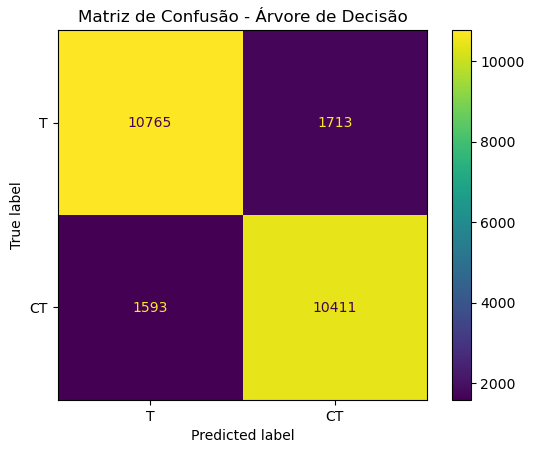

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_labels = ['T', 'CT']

conf_matrix = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp_cm.plot(values_format='d')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()

### 7. Curva ROC e AUC

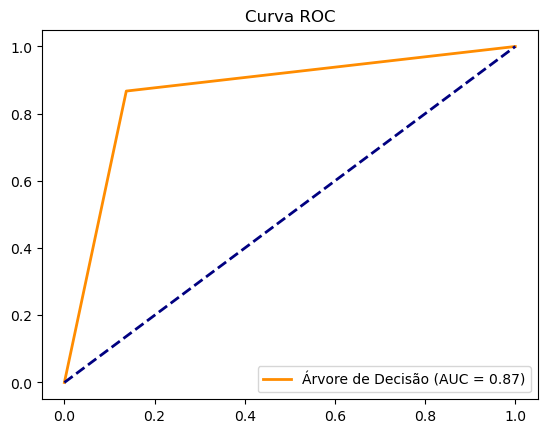

In [78]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Árvore de Decisão (AUC = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### 8. Conclusões

O modelo de classificação utilizado para prever os resultados das partidas com base no tempo de jogo alcançou um desempenho promissor. Apesar do conjunto de dados limitado e da ausência de informações detalhadas sobre cada jogador, o modelo atingiu uma precisão impressionante de 87% no conjunto de testes. Isso sugere que as características selecionadas e o algoritmo de aprendizado de máquina escolhido, um Classificador de Floresta Aleatória, capturaram efetivamente padrões nos dados relacionados aos resultados das partidas.

Podemos observar que as métricas de precisão, recall e f1-score são consistentes para as classes 0 e 1. Isso sugere que o modelo não exibiu um viés significativo em favor de uma classe específica, mostrando-se equilibrado em sua capacidade de identificar tanto as instâncias positivas quanto as negativas. Além disso, alta precisão do modelo indica sua capacidade de generalizar bem para dados não vistos, tornando-o uma ferramenta valiosa para prever os resultados das partidas com base nas características fornecidas. As etapas de engenharia de características, incluindo a transformação de características relacionadas ao tempo e a agregação de informações sobre armas, parecem contribuir positivamente para o desempenho preditivo do modelo.

É importante observar que, embora o modelo tenha um desempenho sólido, avaliações e validações adicionais em conjuntos de dados maiores e cenários diversos seriam benéficas para avaliar sua robustez e generalização. Além disso, a incorporação de informações mais detalhadas sobre os jogadores e a exploração de técnicas avançadas de engenharia de características poderiam aprimorar as capacidades preditivas do modelo.

Em conclusão, o modelo de classificação atual mostra promessa na previsão dos resultados das partidas com base no tempo de jogo, e refinamentos e validações adicionais podem contribuir para sua eficácia em contextos mais amplos.
